In [1]:
import seaborn as sns
import pandas as pd
import json

In [2]:
import os
import glob

In [3]:
def load_metrics_file(file_name):
    with open(file_name, 'r') as f:
        return json.load(f)

In [4]:
def load_metrics(folder):
    server = load_metrics_file(folder + '/server.json')
    clients = [load_metrics_file(f.replace('\\', '/')) for f in glob.glob(folder + '/*.json') if 'server' not in f]
    return server, clients

In [5]:
def join_clients_dataset(clients):
    result = {}
    for c in clients:
        if len(c['traffic_in']) == 0 or len(c['traffic_out']) == 0:
            continue
        for k, v in c.items():
            if k in ['latencies', 'traffic_in', 'traffic_out']:
                continue
            if k in result:
                result[k].append(v)
            else:
                result[k] = [v]
    return pd.DataFrame(result)

In [6]:
def append_server_data(clients, server):
    clients['class'] = 'client'
    server['class'] = 'server'
    row = [server[col] for col in clients]
    clients.loc[len(clients)] = row
    return clients

In [17]:
def form_pandas(clients, server):
    df = append_server_data(join_clients_dataset(clients), server)
    df[['avg_traffic_in', 'avg_traffic_out', 'max_traffic_in', 'max_traffic_out']] /= 1000
    df['traffic_in_total_kb'] = df['traffic_in_total'] / 1000
    df['traffic_out_total_kb'] = df['traffic_out_total'] / 1000
    return df

In [8]:
def get_data(folder):
    server, clients = load_metrics(folder)
    return form_pandas(clients, server)

In [9]:
def extract_series(source, column):
    series = pd.DataFrame(server[column], columns=['time', column])
    return series.set_index('time')

In [10]:
# server, clients = load_metrics('../metrics_cs')
# data = form_pandas(clients, server)

In [11]:
# series = extract_series(server, 'traffic_out')

In [12]:
sns.set_theme(style="whitegrid")

In [13]:
import matplotlib.pyplot as plt 

In [14]:
# sns.set(rc={'figure.figsize':(15,6)})

# sns.lineplot(data=series.iloc[1000:3000], palette="tab10", linewidth=2.5)

In [15]:
def plot_data(data):
    sns.set(rc={'figure.figsize':(15,10)})

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.1, wspace=0.4)
    
    def plot(y, label, palette, idx):
        ax = fig.add_subplot(2, 5, idx)
        g = sns.barplot(
            data=data,
            x="class", y=y,
            ci="sd", palette=palette, alpha=.6,
            ax=ax
        )
        g.set(xlabel='', ylabel=label)
    
    plot('max_latency', 'Max Latency (ms)', 'tab10', 1)
    plot('avg_traffic_in', 'Avg Traffic In (KB)', 'dark', 2)
    plot('max_traffic_in', 'Max Traffic In (KB)', 'dark', 3)
    plot('traffic_in_rate', 'Traffic In Rate (KB/s)', 'dark', 4)
    plot('traffic_in_total_kb', 'Traffic In Total (KB)', 'dark', 5)
    
    plot('avg_latency', 'Avg Latency (ms)', 'tab10', 6)
    plot('avg_traffic_out', 'Avg Traffic out (KB)', 'Set2', 7)
    plot('max_traffic_out', 'Max Traffic out (KB)', 'Set2', 8)
    plot('traffic_out_rate', 'Traffic out Rate (KB/s)', 'Set2', 9)
    plot('traffic_out_total_kb', 'Traffic out Total (KB)', 'Set2', 10)
    
    plt.show()

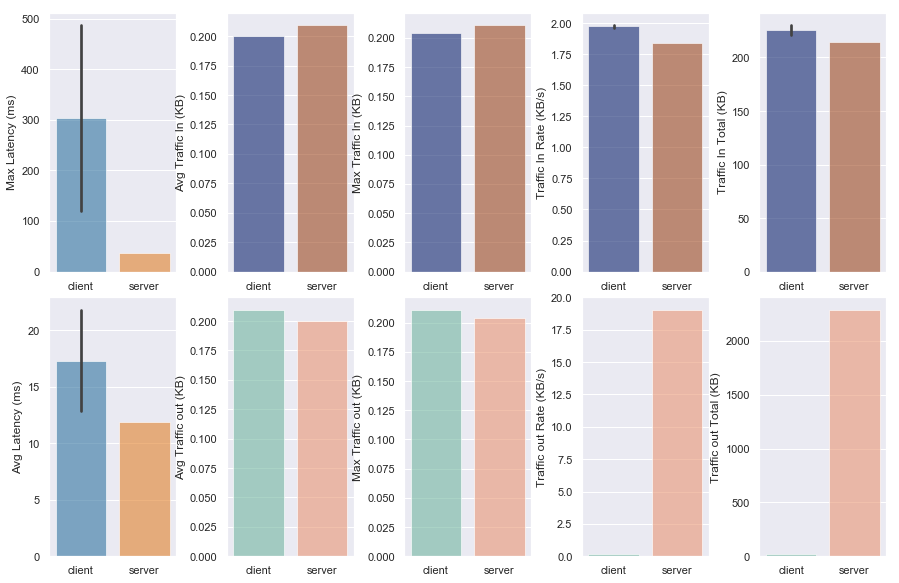

In [18]:
plot_data(get_data('../metrics_cs'))

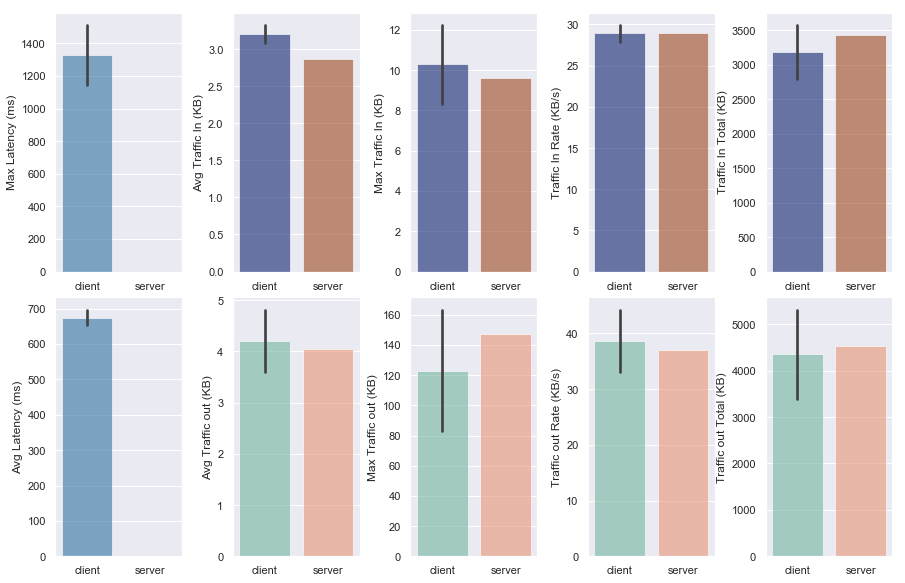

In [19]:
plot_data(get_data('../metrics_gg_10_10'))

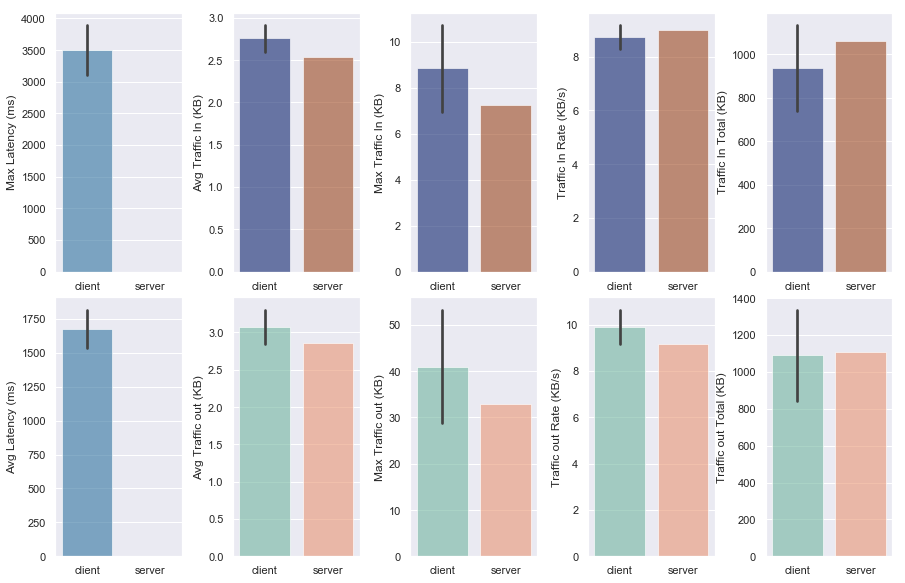

In [20]:
plot_data(get_data('../metrics_gg_3_10'))

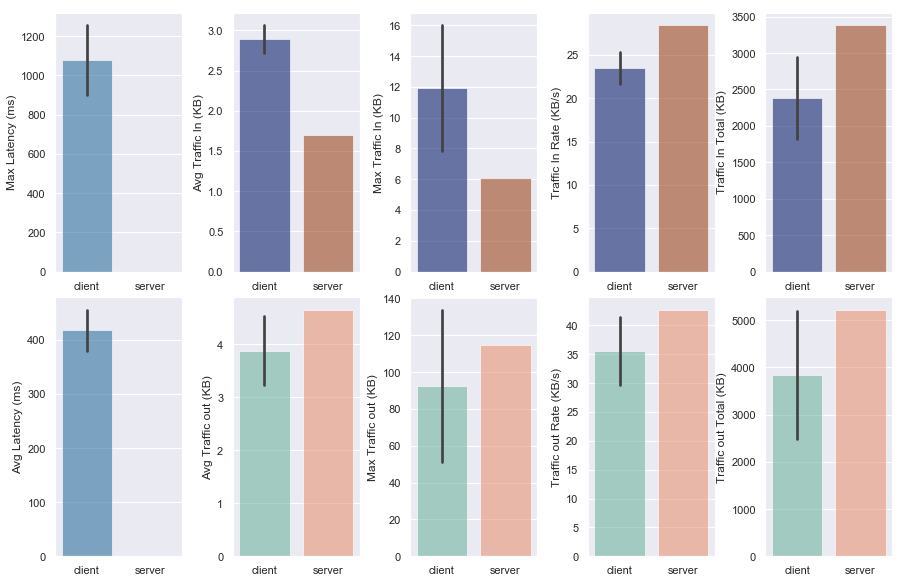

In [24]:
plot_data(get_data('../metrics_gg_ll_10_10'))

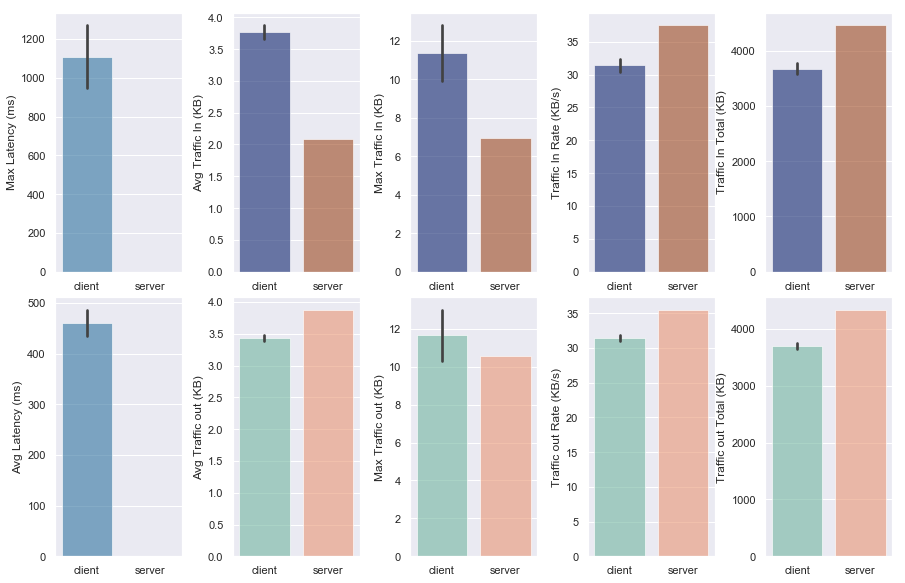

In [27]:
plot_data(get_data('../metrics_gg_alm_10_10'))

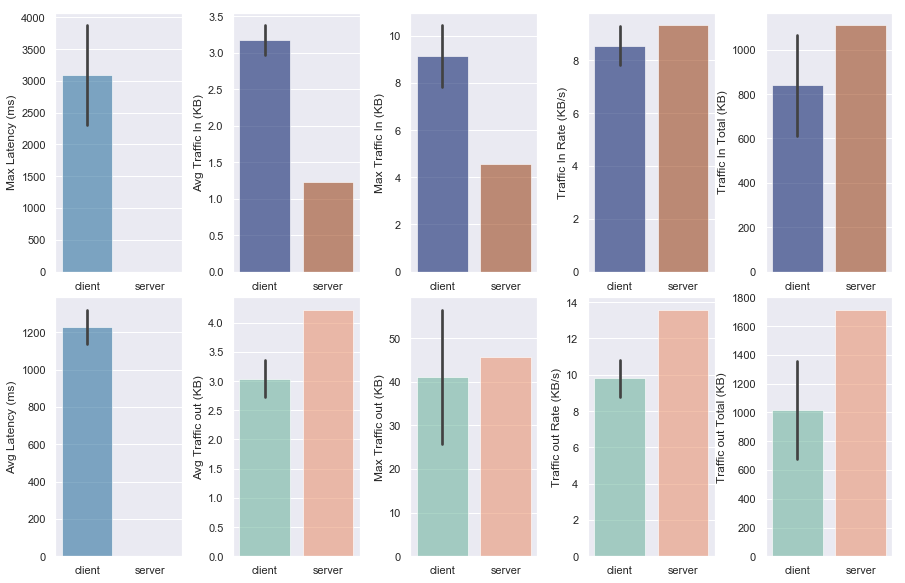

In [28]:
plot_data(get_data('../metrics_gg_alm_3_10'))

In [47]:
def plot_side_by_side(subset):
    df1 = get_data('../metrics_cs'); df1['dataset'] = 'C/S'
    df2 = get_data('../metrics_gg_10_10'); df2['dataset'] = 'GG 10'
    df3 = get_data('../metrics_gg_ll_10_10'); df3['dataset'] = 'GG LL 10'
    df4 = get_data('../metrics_gg_alm_10_10'); df4['dataset'] = 'GG ALM 10'
    df5 = get_data('../metrics_gg_3_10'); df5['dataset'] = 'GG 3'
    df6 = get_data('../metrics_gg_alm_3_10'); df6['dataset'] = 'GG ALM 3'
    
    data = pd.concat([df1, df2, df3, df4, df5, df6])
    
    sns.set(rc={'figure.figsize':(15,10)})

    fig = plt.figure()
    fig.subplots_adjust(hspace=0.1, wspace=0.4)
    
    def plot(y, label, palette, idx):
        ax = fig.add_subplot(2, 2, idx)
        g = sns.barplot(
            data=data[data['class'] == subset],
            x="dataset", y=y,
            ci="sd", palette=palette, alpha=.6,
            ax=ax
        )
        g.set(xlabel='', ylabel=label)
    
    plot('max_latency', 'Max Latency (ms)', 'tab10', 1)
    plot('avg_latency', 'Avg Latency (ms)', 'tab10', 2)
    
    plot('traffic_in_total_kb', 'Traffic In Total (KB)', 'Set2', 3)
    plot('traffic_out_total_kb', 'Traffic out Total (KB)', 'Set2', 4)
    
    plt.show()

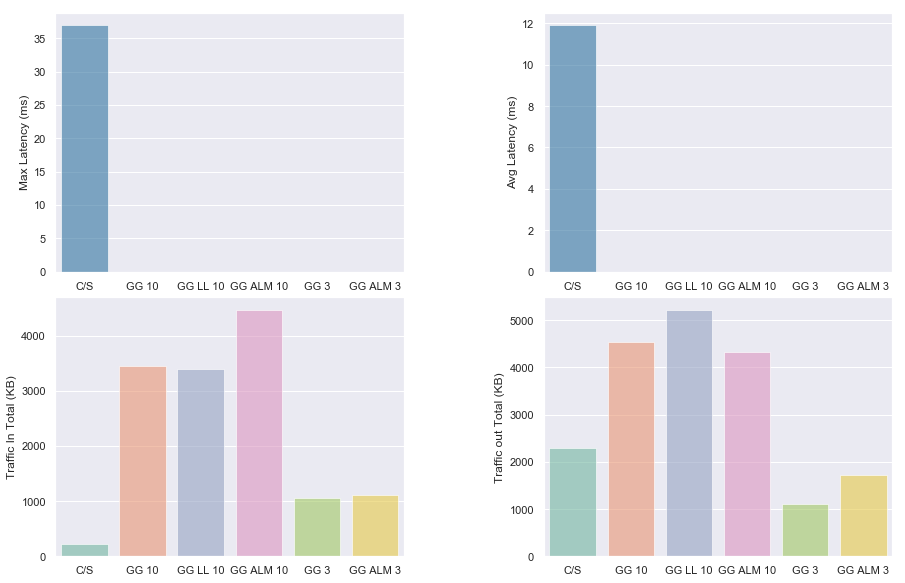

In [48]:
plot_side_by_side('server')

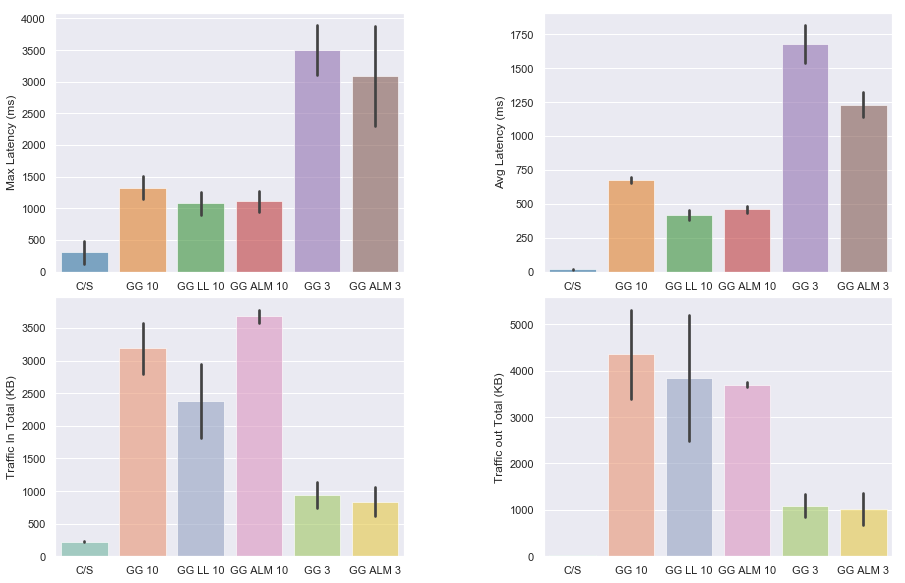

In [49]:
plot_side_by_side('client')